# Training Analysis

Visualize and interpret training runs for the StepMania difficulty classifier.

In [16]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Checkpoint

In [4]:
CHECKPOINT_MAINDIR = Path('../checkpoints')
CHECKPOINT_SUBDIR = Path('classifier_01_03_01-05')

CHECKPOINT_DIR = CHECKPOINT_MAINDIR / CHECKPOINT_SUBDIR

# List available checkpoints
checkpoints = list(CHECKPOINT_DIR.glob('*.pt'))
print("Available checkpoints:")
for cp in sorted(checkpoints):
    print(f"  {cp.name}")

Available checkpoints:
  best_val_loss.pt
  last.pt


In [5]:
# Load best checkpoint
checkpoint_path = CHECKPOINT_DIR / 'last.pt'
if not checkpoint_path.exists():
    checkpoint_path = CHECKPOINT_DIR / 'last.pt'

checkpoint = torch.load(checkpoint_path, map_location='cpu')
print(f"Loaded: {checkpoint_path.name}")
print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")

history = checkpoint.get('history', {})

Loaded: last.pt
Epoch: 6
Best val loss: 0.3762


## 1.5 Training Data Distribution

Class balance from the actual data used during training (logged in checkpoint).

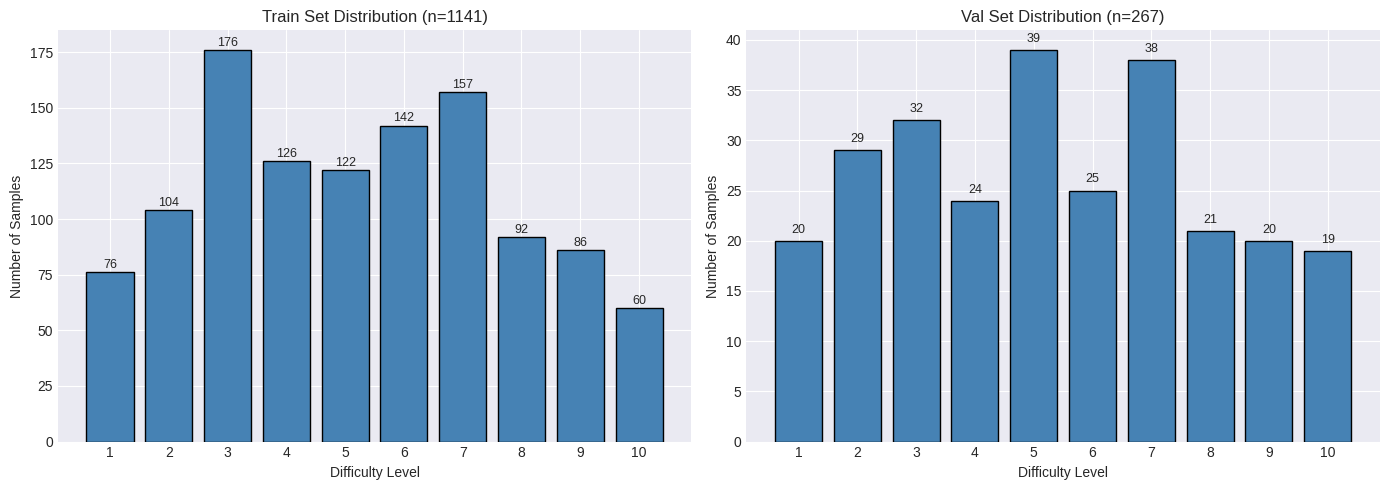


Data Distribution Summary:

TRAIN (1141 samples):
  Difficulty  1:   76 (  6.7%) ###
  Difficulty  2:  104 (  9.1%) ####
  Difficulty  3:  176 ( 15.4%) #######
  Difficulty  4:  126 ( 11.0%) #####
  Difficulty  5:  122 ( 10.7%) #####
  Difficulty  6:  142 ( 12.4%) ######
  Difficulty  7:  157 ( 13.8%) ######
  Difficulty  8:   92 (  8.1%) ####
  Difficulty  9:   86 (  7.5%) ###
  Difficulty 10:   60 (  5.3%) ##

VAL (267 samples):
  Difficulty  1:   20 (  7.5%) ###
  Difficulty  2:   29 ( 10.9%) #####
  Difficulty  3:   32 ( 12.0%) #####
  Difficulty  4:   24 (  9.0%) ####
  Difficulty  5:   39 ( 14.6%) #######
  Difficulty  6:   25 (  9.4%) ####
  Difficulty  7:   38 ( 14.2%) #######
  Difficulty  8:   21 (  7.9%) ###
  Difficulty  9:   20 (  7.5%) ###
  Difficulty 10:   19 (  7.1%) ###


In [6]:
# Display data distribution from checkpoint (if available)
data_info = checkpoint.get('data_info', None)

if data_info:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for idx, (split_name, split_info) in enumerate(data_info.items()):
        ax = axes[idx]
        dist = split_info['difficulty_distribution']

        # Convert to arrays for plotting
        difficulties = list(range(1, 11))
        counts = [dist.get(d, 0) for d in difficulties]

        bars = ax.bar(difficulties, counts, color='steelblue', edgecolor='black')
        ax.set_xlabel('Difficulty Level')
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'{split_name.capitalize()} Set Distribution (n={split_info["total_samples"]})')
        ax.set_xticks(difficulties)

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       str(count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nData Distribution Summary:")
    for split_name, split_info in data_info.items():
        dist = split_info['difficulty_distribution']
        total = split_info['total_samples']
        print(f"\n{split_name.upper()} ({total} samples):")
        for d in range(1, 11):
            count = dist.get(d, 0)
            pct = count / total * 100 if total > 0 else 0
            bar = '#' * int(pct / 2)
            print(f"  Difficulty {d:2d}: {count:4d} ({pct:5.1f}%) {bar}")
else:
    print("No data_info in checkpoint.")
    print("Re-run training to log data distribution (trainer now saves this automatically).")

## 2. Loss Curves

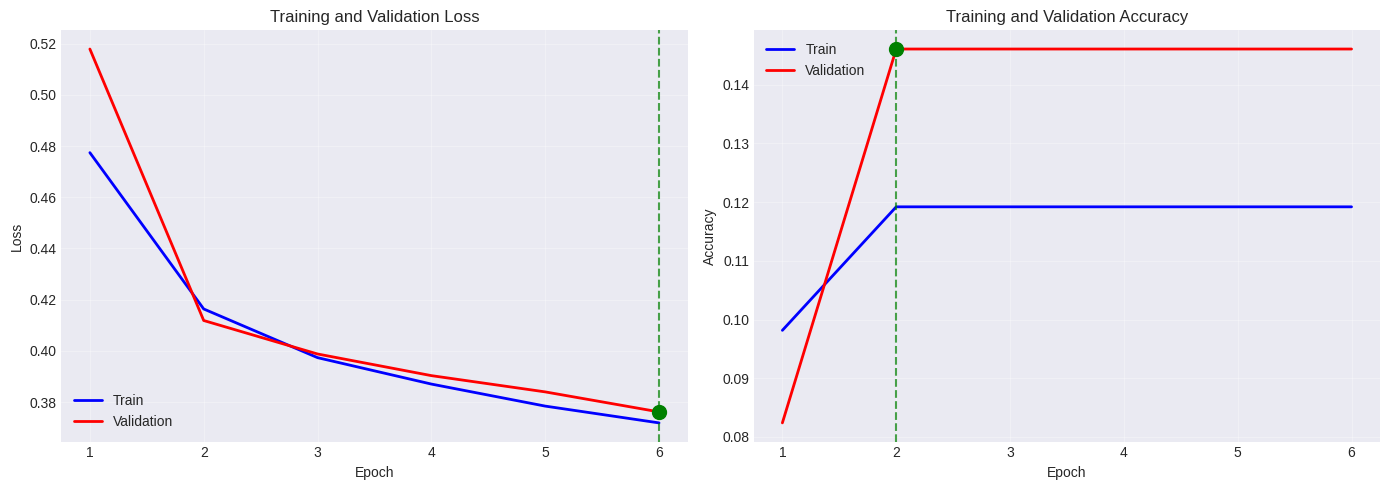

Best validation loss: 0.3762 at epoch 6
Best validation accuracy: 0.1461 at epoch 2


In [7]:
if history:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax = axes[0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Find best epoch
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = min(history['val_loss'])
    ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (epoch {best_epoch})')
    ax.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
    
    # Accuracy
    ax = axes[1]
    ax.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    best_val_acc = max(history['val_acc'])
    best_acc_epoch = np.argmax(history['val_acc']) + 1
    ax.axvline(best_acc_epoch, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_acc_epoch], [best_val_acc], color='green', s=100, zorder=5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_acc_epoch}")
else:
    print("No history found in checkpoint")

## 3. Overfitting Analysis

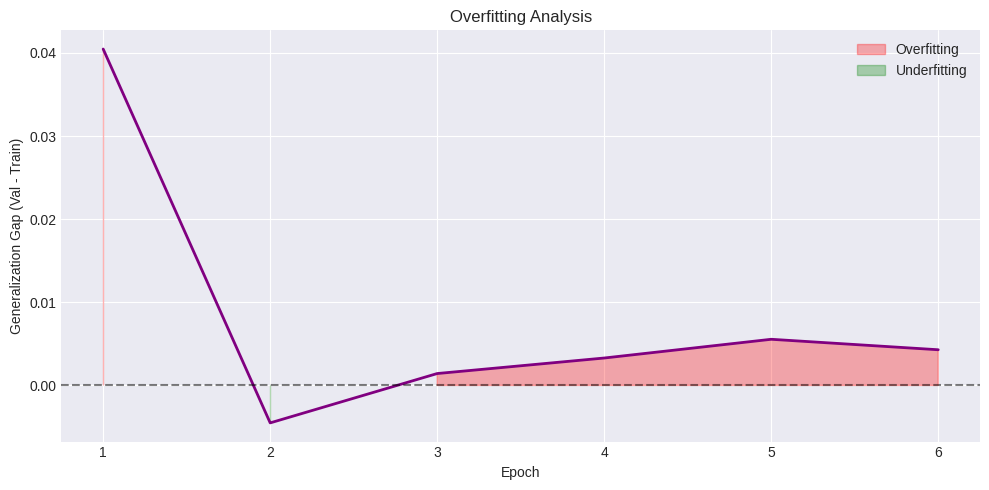

Good generalization (gap: 0.004)


In [8]:
if history and len(history['train_loss']) > 5:
    # Compute generalization gap
    train_loss = np.array(history['train_loss'])
    val_loss = np.array(history['val_loss'])
    gap = val_loss - train_loss
    
    fig, ax = plt.subplots(figsize=(10, 5))
    epochs = range(1, len(gap) + 1)
    ax.plot(epochs, gap, 'purple', linewidth=2)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.fill_between(epochs, 0, gap, where=(gap > 0), color='red', alpha=0.3, label='Overfitting')
    ax.fill_between(epochs, 0, gap, where=(gap <= 0), color='green', alpha=0.3, label='Underfitting')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Generalization Gap (Val - Train)')
    ax.set_title('Overfitting Analysis')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Summary
    final_gap = gap[-1]
    if final_gap > 0.5:
        print(f"WARNING: Significant overfitting detected (gap: {final_gap:.3f})")
        print("Consider: more dropout, data augmentation, or early stopping")
    elif final_gap < -0.1:
        print(f"Model may be underfitting (gap: {final_gap:.3f})")
        print("Consider: larger model, more epochs, or lower regularization")
    else:
        print(f"Good generalization (gap: {final_gap:.3f})")

## 4. Learning Rate Analysis

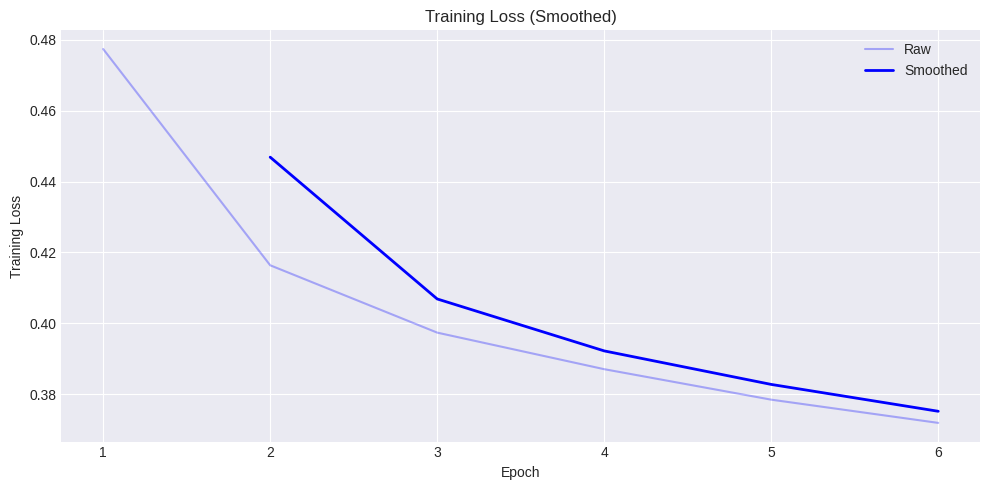

In [9]:
if history:
    # Compute smoothed loss derivative to detect learning rate issues
    train_loss = np.array(history['train_loss'])
    
    # Simple moving average
    window = min(5, len(train_loss) // 3)
    if window > 1:
        smoothed = np.convolve(train_loss, np.ones(window)/window, mode='valid')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(1, len(train_loss) + 1), train_loss, 'b-', alpha=0.3, label='Raw')
        ax.plot(range(window, len(train_loss) + 1), smoothed, 'b-', linewidth=2, label='Smoothed')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Training Loss')
        ax.set_title('Training Loss (Smoothed)')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # Check for plateaus
        recent_change = (smoothed[-1] - smoothed[-min(5, len(smoothed))]) / smoothed[-min(5, len(smoothed))]
        if abs(recent_change) < 0.01:
            print("Training has plateaued - LR reduction may have kicked in")

## 5. Confusion Matrix (if available)

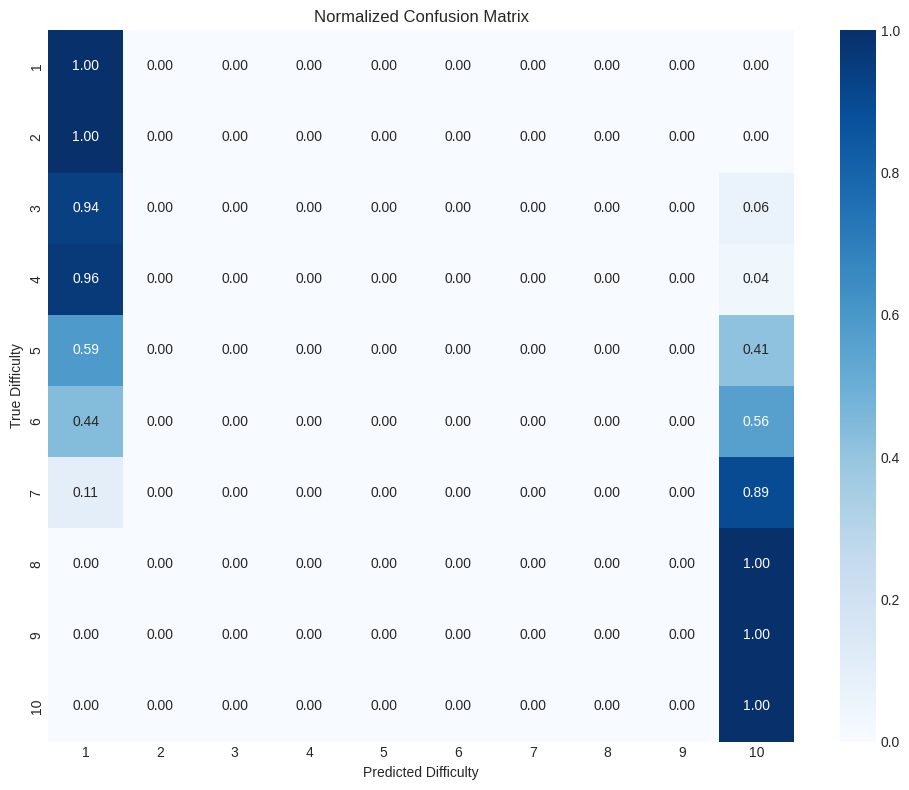


Per-class accuracy:
  Difficulty  1: 1.00 ####################
  Difficulty  2: 0.00 
  Difficulty  3: 0.00 
  Difficulty  4: 0.00 
  Difficulty  5: 0.00 
  Difficulty  6: 0.00 
  Difficulty  7: 0.00 
  Difficulty  8: 0.00 
  Difficulty  9: 0.00 
  Difficulty 10: 1.00 ####################


In [10]:
# Try to get confusion matrix from checkpoint
confusion_matrix = checkpoint.get('confusion_matrix', None)

# Also check inside metrics dict (where trainer actually saves it)
if confusion_matrix is None and 'metrics' in checkpoint:
    confusion_matrix = checkpoint['metrics'].get('confusion_matrix', None)

if confusion_matrix is not None:
    if isinstance(confusion_matrix, torch.Tensor):
        confusion_matrix = confusion_matrix.cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Normalize by row (true labels) - handle zero rows safely
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    cm_normalized = np.divide(confusion_matrix.astype('float'), row_sums, 
                              where=row_sums!=0, out=np.zeros_like(confusion_matrix, dtype=float))
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=range(1, 11), yticklabels=range(1, 11), ax=ax)
    ax.set_xlabel('Predicted Difficulty')
    ax.set_ylabel('True Difficulty')
    ax.set_title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    per_class_acc = np.diag(cm_normalized)
    print("\nPer-class accuracy:")
    for i, acc in enumerate(per_class_acc):
        bar = '#' * int(acc * 20)
        print(f"  Difficulty {i+1:2d}: {acc:.2f} {bar}")
else:
    print("No confusion matrix in checkpoint.")
    print("Run validation with confusion matrix tracking to generate one.")

## 5.1 Confusion Pattern Analysis

Analyze where misclassifications go: off-by-1 errors vs distant jumps.

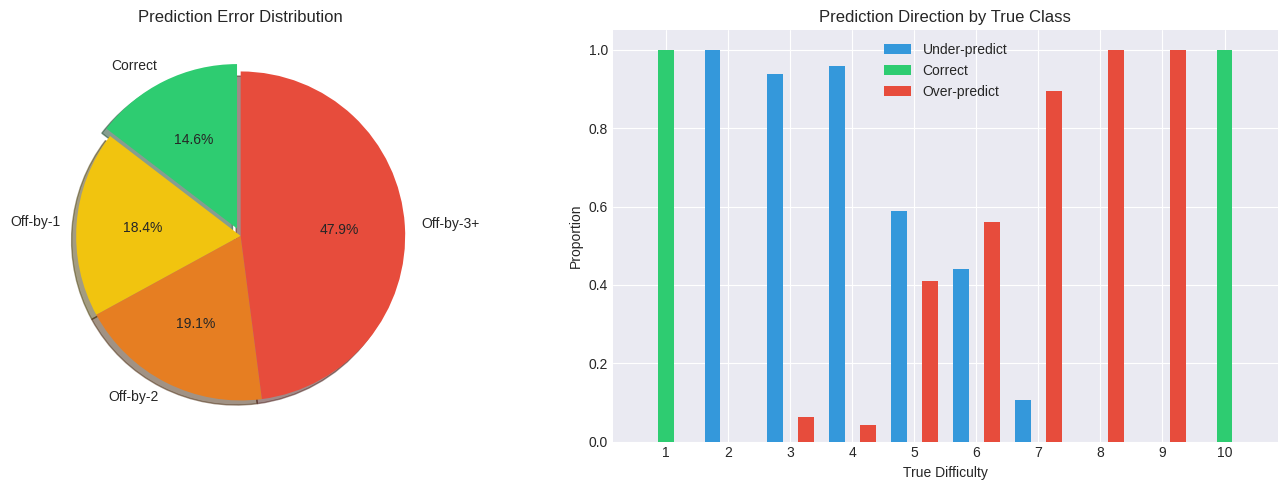

Error Analysis Summary:
  Total samples:  267
  Correct:        39 (14.6%)
  Off-by-1:       49 (18.4%)
  Off-by-2:       51 (19.1%)
  Off-by-3+:      128 (47.9%)

  Mean Absolute Error (MAE): 2.431
  (Lower is better - perfect model has MAE=0)

  Many distant errors - model has fundamental discrimination issues


In [11]:
if confusion_matrix is not None:
    cm = confusion_matrix.astype('float')
    num_classes = cm.shape[0]
    total_samples = cm.sum()

    if total_samples == 0:
        print("Confusion matrix is empty (no samples).")
    else:
        # Categorize errors by distance
        correct = np.trace(cm)
        off_by_1 = 0
        off_by_2 = 0
        off_by_3_plus = 0

        for i in range(num_classes):
            for j in range(num_classes):
                if i == j:
                    continue
                distance = abs(i - j)
                if distance == 1:
                    off_by_1 += cm[i, j]
                elif distance == 2:
                    off_by_2 += cm[i, j]
                else:
                    off_by_3_plus += cm[i, j]

        total_errors = total_samples - correct

        # Calculate MAE from confusion matrix
        mae = 0
        for i in range(num_classes):
            for j in range(num_classes):
                mae += cm[i, j] * abs(i - j)
        mae /= total_samples

        # Visualize error distribution
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Pie chart of error types
        ax = axes[0]
        sizes = [correct, off_by_1, off_by_2, off_by_3_plus]
        labels = ['Correct', 'Off-by-1', 'Off-by-2', 'Off-by-3+']
        colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
        explode = (0.05, 0, 0, 0)
        ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=90)
        ax.set_title('Prediction Error Distribution')

        # Error flow diagram (where do errors go?)
        ax = axes[1]
        error_flow = np.zeros((num_classes, 3))  # [under-predict, correct, over-predict]
        for i in range(num_classes):
            for j in range(num_classes):
                if j < i:
                    error_flow[i, 0] += cm[i, j]  # Under-predicted
                elif j == i:
                    error_flow[i, 1] += cm[i, j]  # Correct
                else:
                    error_flow[i, 2] += cm[i, j]  # Over-predicted

        # Normalize by row - handle zero rows safely
        row_sums = error_flow.sum(axis=1, keepdims=True)
        error_flow_norm = np.divide(error_flow, row_sums, where=row_sums!=0, 
                                    out=np.zeros_like(error_flow))

        x = np.arange(1, 11)
        width = 0.25
        ax.bar(x - width, error_flow_norm[:, 0], width, label='Under-predict', color='#3498db')
        ax.bar(x, error_flow_norm[:, 1], width, label='Correct', color='#2ecc71')
        ax.bar(x + width, error_flow_norm[:, 2], width, label='Over-predict', color='#e74c3c')
        ax.set_xlabel('True Difficulty')
        ax.set_ylabel('Proportion')
        ax.set_title('Prediction Direction by True Class')
        ax.set_xticks(x)
        ax.legend()

        plt.tight_layout()
        plt.show()

        # Print summary
        print("Error Analysis Summary:")
        print(f"  Total samples:  {int(total_samples)}")
        print(f"  Correct:        {int(correct)} ({100*correct/total_samples:.1f}%)")
        print(f"  Off-by-1:       {int(off_by_1)} ({100*off_by_1/total_samples:.1f}%)")
        print(f"  Off-by-2:       {int(off_by_2)} ({100*off_by_2/total_samples:.1f}%)")
        print(f"  Off-by-3+:      {int(off_by_3_plus)} ({100*off_by_3_plus/total_samples:.1f}%)")
        print(f"")
        print(f"  Mean Absolute Error (MAE): {mae:.3f}")
        print(f"  (Lower is better - perfect model has MAE=0)")

        # Interpretation
        if total_errors > 0:
            if off_by_1 / total_errors > 0.5:
                print(f"\n  Most errors are adjacent - ordinal regression may help!")
            elif off_by_3_plus / total_errors > 0.3:
                print(f"\n  Many distant errors - model has fundamental discrimination issues")
else:
    print("No confusion matrix available for error analysis.")

## 5.2 Per-Class Precision, Recall, and F1

Detailed classification metrics for each difficulty level.

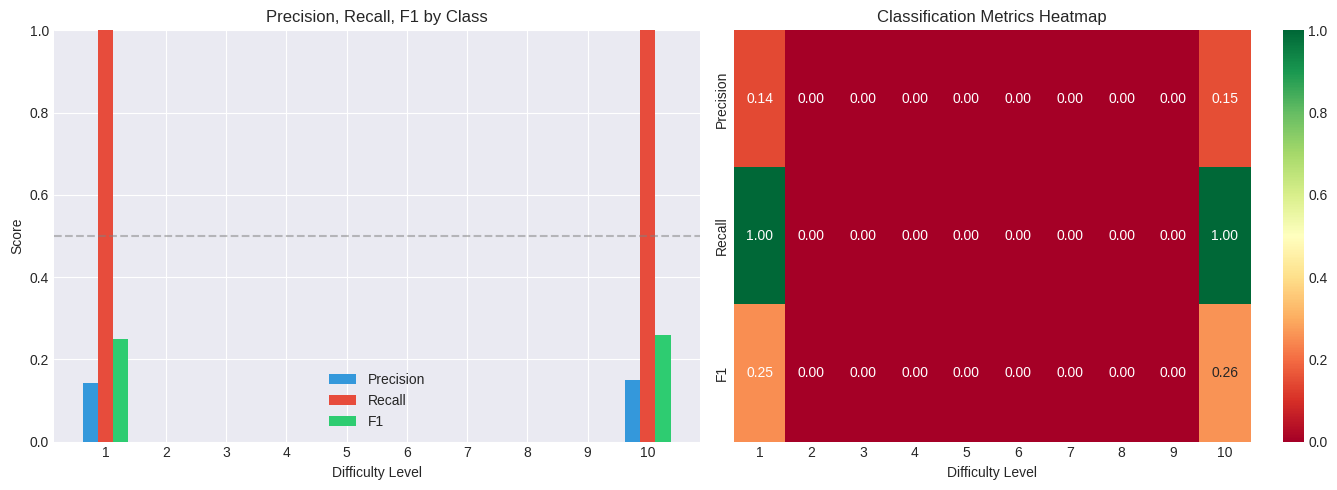

Per-Class Classification Metrics:
------------------------------------------------------------
Difficulty  Precision     Recall         F1    Support
------------------------------------------------------------
         1      0.143      1.000      0.250         20
         2      0.000      0.000      0.000         29
         3      0.000      0.000      0.000         32
         4      0.000      0.000      0.000         24
         5      0.000      0.000      0.000         39
         6      0.000      0.000      0.000         25
         7      0.000      0.000      0.000         38
         8      0.000      0.000      0.000         21
         9      0.000      0.000      0.000         20
        10      0.150      1.000      0.260         19
------------------------------------------------------------
 Macro Avg      0.029      0.200      0.051        267
  Weighted      0.021      0.146      0.037        267

Problem classes (F1 < 0.3): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Diffi

In [12]:
if confusion_matrix is not None:
    cm = confusion_matrix.astype('float')
    num_classes = cm.shape[0]

    # Calculate precision, recall, F1 for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    support = np.zeros(num_classes)

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp  # Column sum minus diagonal
        fn = cm[i, :].sum() - tp  # Row sum minus diagonal

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        support[i] = cm[i, :].sum()

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart of metrics
    ax = axes[0]
    x = np.arange(1, 11)
    width = 0.25
    ax.bar(x - width, precision, width, label='Precision', color='#3498db')
    ax.bar(x, recall, width, label='Recall', color='#e74c3c')
    ax.bar(x + width, f1, width, label='F1', color='#2ecc71')
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall, F1 by Class')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

    # Heatmap of metrics
    ax = axes[1]
    metrics_matrix = np.vstack([precision, recall, f1])
    sns.heatmap(metrics_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
                xticklabels=range(1, 11), yticklabels=['Precision', 'Recall', 'F1'],
                ax=ax, vmin=0, vmax=1, center=0.5)
    ax.set_xlabel('Difficulty Level')
    ax.set_title('Classification Metrics Heatmap')

    plt.tight_layout()
    plt.show()

    # Print detailed table
    print("Per-Class Classification Metrics:")
    print("-" * 60)
    print(f"{'Difficulty':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
    print("-" * 60)
    for i in range(num_classes):
        print(f"{i+1:>10} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f} {int(support[i]):>10}")
    print("-" * 60)

    # Macro and weighted averages
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()

    weighted_precision = (precision * support).sum() / support.sum()
    weighted_recall = (recall * support).sum() / support.sum()
    weighted_f1 = (f1 * support).sum() / support.sum()

    print(f"{'Macro Avg':>10} {macro_precision:>10.3f} {macro_recall:>10.3f} {macro_f1:>10.3f} {int(support.sum()):>10}")
    print(f"{'Weighted':>10} {weighted_precision:>10.3f} {weighted_recall:>10.3f} {weighted_f1:>10.3f} {int(support.sum()):>10}")

    # Identify problem classes
    problem_classes = np.where(f1 < 0.3)[0]
    if len(problem_classes) > 0:
        print(f"\nProblem classes (F1 < 0.3): {[c+1 for c in problem_classes]}")
        for c in problem_classes:
            if recall[c] < precision[c]:
                print(f"  Difficulty {c+1}: Low recall - model misses many samples of this class")
            else:
                print(f"  Difficulty {c+1}: Low precision - model over-predicts this class")
else:
    print("No confusion matrix available for metrics calculation.")

## 6. Training Summary

In [13]:
print("=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)

if history:
    n_epochs = len(history['train_loss'])
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    best_val_loss = min(history['val_loss'])
    best_val_acc = max(history['val_acc'])
    
    print(f"Epochs completed: {n_epochs}")
    print(f"")
    print(f"Final metrics:")
    print(f"  Train loss: {final_train_loss:.4f}")
    print(f"  Val loss:   {final_val_loss:.4f}")
    print(f"  Train acc:  {final_train_acc:.4f}")
    print(f"  Val acc:    {final_val_acc:.4f}")
    print(f"")
    print(f"Best metrics:")
    print(f"  Val loss:   {best_val_loss:.4f}")
    print(f"  Val acc:    {best_val_acc:.4f}")
    print(f"")
    
    # Recommendations
    print("Recommendations:")
    if final_val_acc < 0.3:
        print("  - Model struggling. Check data quality and class balance.")
    elif final_val_acc < 0.5:
        print("  - Moderate performance. Consider longer training or architecture changes.")
    elif final_val_acc < 0.7:
        print("  - Good progress. Fine-tune hyperparameters for better results.")
    else:
        print("  - Strong performance! Consider ensemble or test set evaluation.")
    
    if final_val_loss > final_train_loss * 1.5:
        print("  - Overfitting detected. Add regularization or data augmentation.")
else:
    print("No training history available.")

TRAINING SUMMARY
Epochs completed: 6

Final metrics:
  Train loss: 0.3719
  Val loss:   0.3762
  Train acc:  0.1192
  Val acc:    0.1461

Best metrics:
  Val loss:   0.3762
  Val acc:    0.1461

Recommendations:
  - Model struggling. Check data quality and class balance.


## 7. Model Architecture Info

In [14]:
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
    
    # Count parameters
    total_params = sum(p.numel() for p in state_dict.values())
    
    print(f"Total parameters: {total_params:,}")
    print(f"")
    print("Layer sizes:")
    for name, param in state_dict.items():
        if 'weight' in name:
            print(f"  {name}: {list(param.shape)}")

Total parameters: 2,733,138

Layer sizes:
  audio_encoder.net.0.conv.weight: [128, 13, 3]
  audio_encoder.net.0.norm.weight: [128]
  audio_encoder.net.1.conv.weight: [128, 128, 3]
  audio_encoder.net.1.norm.weight: [128]
  chart_encoder.chart_embedding.weight: [64, 4]
  chart_encoder.net.0.conv.weight: [128, 64, 3]
  chart_encoder.net.0.norm.weight: [128]
  chart_encoder.net.1.conv.weight: [128, 128, 3]
  chart_encoder.net.1.norm.weight: [128]
  fusion_module.fusion_proj.weight: [256, 256]
  fusion_module.norm.weight: [256]
  backbone.input_conv.conv.weight: [256, 256, 3]
  backbone.input_conv.norm.weight: [256]
  backbone.pre_downsample_res.conv1.conv.weight: [256, 256, 3]
  backbone.pre_downsample_res.conv1.norm.weight: [256]
  backbone.pre_downsample_res.conv2.conv.weight: [256, 256, 3]
  backbone.pre_downsample_res.conv2.norm.weight: [256]
  backbone.downsample.conv.conv.weight: [256, 256, 3]
  backbone.downsample.conv.norm.weight: [256]
  backbone.res_blocks.0.conv1.conv.weight: [

## 8. Chart Statistics Correlation (if available)

Analyze how the engineered chart statistics features correlate with difficulty levels.

In [15]:
# Chart statistics analysis
# Shows how chart features correlate with difficulty levels

chart_stats_summary = checkpoint.get('chart_stats_summary', None)

if chart_stats_summary is not None:
    stat_names = ['Notes/sec', 'Jump ratio', 'Max stream', 'Avg gap', 'Peak density']
    
    # Extract means for each difficulty
    difficulties = sorted([d for d in chart_stats_summary.keys() if isinstance(d, int)])
    means = np.array([chart_stats_summary[d]['mean'] for d in difficulties])
    stds = np.array([chart_stats_summary[d]['std'] for d in difficulties])
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (name, ax) in enumerate(zip(stat_names, axes[:5])):
        ax.bar(difficulties, means[:, i], yerr=stds[:, i], capsize=3, 
               color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Difficulty Level')
        ax.set_ylabel(name)
        ax.set_title(f'{name} by Difficulty')
        ax.set_xticks(difficulties)
    
    # Hide unused subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print table
    print("\nChart Statistics by Difficulty Level (mean ± std):")
    print("-" * 90)
    print(f"{'Diff':>5} {'Count':>6} " + " ".join(f"{name:>14}" for name in stat_names))
    print("-" * 90)
    
    for d in difficulties:
        stats = chart_stats_summary[d]
        count = stats['count']
        mean_vals = stats['mean']
        std_vals = stats['std']
        row = f"{d:>5} {count:>6} "
        for m, s in zip(mean_vals, std_vals):
            row += f"{m:>6.3f}±{s:<6.3f} "
        print(row)
    
    # Correlation analysis
    print("\nFeature-Difficulty Correlation:")
    for i, name in enumerate(stat_names):
        corr = np.corrcoef(difficulties, means[:, i])[0, 1]
        direction = "↑" if corr > 0 else "↓"
        strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
        print(f"  {name:15s}: r={corr:+.3f} ({strength} {direction})")
else:
    print("No chart_stats_summary in checkpoint.")
    print("Retrain to generate this data (trainer now saves it automatically).")

No chart_stats_summary in checkpoint.
Retrain to generate this data (trainer now saves it automatically).
